# Prosessering av STEM-DPC data

Denne Jupyter Notebooken viser hvordan Scanning Transmission Electron Microscopy - Differential Phase Contrast (STEM-DPC) data kan analyseres. Dette gjøres ved å bruke en relativt enkel metode: thresholded center of mass.

Eksempel på bilde:

<img src="eksempelbilde_dpc.jpg" width=300 height=300 />

## Importere biblioteker

Først, plotte-biblioteket. Dette kan enten være `%matplotlib qt` for egne vinduer for plottene, eller `%matplotlib widget` for å få plottene i selve Jupyter Notebooken.

In [1]:
%matplotlib qt

Så importere HyperSpy

In [2]:
import hyperspy.api as hs

## Åpne dataset

Dette gjøres via `hs.load`, som kan åpne en rekke dataformater, spesielt innenfor elektronmikroskopi. Merk at STEM-DPC datasettene vanligvis er ganske store, så bruk `lazy=True`.

Lag et objekt som heter `s`.

Tips: sjekk docstring for informasjon om hvordan `hs.load` virker.

In [9]:
s = hs.load('stem_dpc_256x256_2msexp_50msfb_tworings.hspy', lazy=True)

Skriv `s` i cellen under, og kjør cellen.

In [10]:
s

<LazyElectronDiffraction2D, title: , dimensions: (256, 256|256, 256)>

Her ser vi at dette er et `LazyElectronDiffraction2D` signal. `Lazy` betyr at dataene er ikke overført til RAM, ergo at dataene ennå bare er på harddisken. I tillegg ser vi at datasettet har `256 x 256` probe-posisjoner, og `256 x 256` detektorposisjoner. Hvert datapunkt er en 16-bit heltall, som gir 2 bytes. Dette gir en datastørrelse på: `256 * 256 * 256 * 256 * 2`, som er ca. 8.6 gigabytes.

En del av dere har nok en datamaskin som kan takle dette, men la oss prøve å redusere datamengden litt.

**VIKTIG:** det er veldig lett å kræsje datamaskinen når man holder på med såpass store datasett. Så pass på at dere har lagret ting dere har åpent.

## Plotting av dataen

`s` inneholder er et signal objekt som inneholder mange funksjoner. Et av disse er `plot`, prøv denne. Siden dette er et `lazy` signal, så må HyperSpy kalkulere et navigasjonsbilde ved å hente ut deler (`chunks`) av gangen.

Denne navigeringen kommer (mest sannsynlig) til å være ganske treg, dette fordi alt må leses fra harddisken. Planen nå er å redusere datastørrelsen, slik at vi kan laste alt inn i minnet.

Tips: navigatoren kan gjøres større ved å trykke på `+` knappen. Og mindre med å trykke på `-` knappen. Dette summerer IKKE flere piksler, men er bare en måte å lettere treffe navigator-markøren.
Tips 2: dere kan også flytte rundt med pil-tastene.

(Siden folk har litt forskjellige datasett, så er det sannsynlig at ikke alt dette er relevant for alle.)

In [11]:
s.plot()

[########################################] | 100% Completed |  2.5s


Siden vi bare er interessert i senter-disken, så kan vi fjerne alt "tomrommet" hvor elektronstrålen ikke er. Ergo: vi beskjærer datasettet, slik at vi bare får de delene vi bryr oss om.

Et vanlig problem, er at elektronstrålen flytter seg som funksjon av probe-posisjon.

Så: bruk navigatoren til å gå øverst til venstre, øverst til høyre, nederst til venstre og nederst til høyre. Merk hvor langt "ut" elektronstrålen flytter seg. Bruk muse-pekeren til å se x- og y- verdiene til disse punktene.

Hvis deler av datasettet er "dekket" av tykke deler av prøven, som dere ikke bryr dere om, så bare gjør dette med de områdene som er tynne nok. Hvis du har sånne "uinteressante" områder, så bruk `inav` til å fjerne dem på en tilsvarende måte.

Så bruk `isig` til å beskjære. Syntaksen er: `s.isig[x0:x1, y0:y1]`, lagre dette som en ny variabel: `s1`

SyntaxError: invalid syntax (Temp/ipykernel_18140/518842052.py, line 1)

In [12]:
s1 = s.isig[70:180, 80:170]

Skriv `s1` i cellen under, og kjør cellen.

In [13]:
s1

<LazyElectronDiffraction2D, title: , dimensions: (256, 256|110, 90)>

Her ser vi at dette er et `LazyElectronDiffraction2D` signal, men med færre detektor-posisjoner!

For å sjekke hvordan dette ser ut, så bruk: s1.plot()

In [14]:
s1.plot()

[########################################] | 100% Completed |  2.4s


Hvis dette ser bra ut, og datamengden har blitt redusert til f.eks. 25% av den orginale størrelsen til `s`, så bruk `compute` funksjonen i `s1`.

**VIKTIG:** dette vil laste hele `s1` datasettet inn i minnet, og hvis du ikke har gjort forrige steg riktig, så kan det kræsje datamaskinen din!

In [16]:
s1.compute()

[########################################] | 100% Completed | 13.1s


Nå vil plottingen være mye raskere, siden alt er i minnet. Bruk `plot` i `s1`, for å se hvordan prøven og datasettet ser ut.

In [17]:
s1.plot()

## Magnetisk kontrast

Nå som datasettet er litt mer håndterbart, så kan vi prøve å se de magnetiske domenene.

En enkel måte å gjøre dette på, er å bytte om på "navigasjon" og "signal" aksene. Ergo: istedet for at vi endrer på probe-posisjonen, så endrer vi heller på detektorposisjonen.

Kjør: `s1.T.plot()`, og flytt navigatoren rundt senterstrålen.

In [18]:
s1.T.plot()

## Mer avansert analyse

En litt mer avansert måte å analysere dette, er å bruk `center_of_mass` i `s1`. Lagre dette som `s1_com`. Dette regner ut hvor senter-posisjonen er for alle probe-posisjonene.

Tips: bruk `threshold=2` for å forbedre kontrasten.

In [20]:
s1_com = s1.center_of_mass(threshold=2)

[########################################] | 100% Completed |  7.7s


Dette gir et `DPCSignal2D`, hvor x- og y-posisjonene er i navigasjonsposisjonene.

Bruk `plot` i `s1_com`.

Tips: bruk kontrast-editoren, ved å trykke på `H`-knappen.

In [21]:
s1_com.plot()

Her ser vi at vi har et problem med at senter-strålen har flyttet seg, som gir et "plan" i både x- og y-retningen.

Dette kan korrigeres ved å bruk `correct_ramp` funksjonen i `s1_com`.

Bruk denne, og lagre den som `s1_com_corr`.

In [22]:
s1_com_corr = s1_com.correct_ramp()

In [23]:
s1_com_corr.get_color_signal().plot()

Så plot `s1_com_corr`, ved å bruke `get_color_signal().plot()`

## Plotting av disse dataene

Først lag en `fig` og en `ax` via matplotlib.

Så bruk `get_color_image_with_indicator` i `s1_com_corr` med `ax=ax`.

In [28]:
import matplotlib.pyplot as plt

In [29]:
fig, ax = plt.subplots()

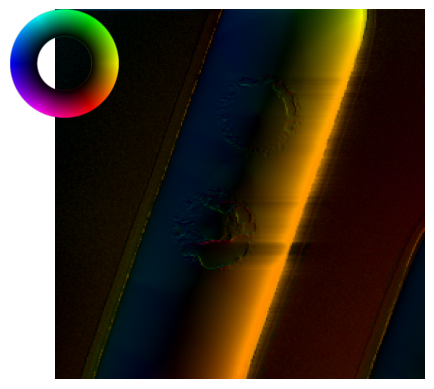

In [30]:
s1_com_corr.get_color_image_with_indicator(ax=ax)

Dette kan så brukes til å lage en ordentlig figur.